In [126]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

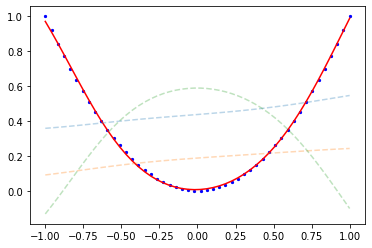

In [165]:
function = lambda x: np.power(x, 2)

num_examples = 50

function_x = torch.from_numpy(np.linspace(-1, 1, num_examples)).float()
function_y = torch.from_numpy(np.array(list(map(function, function_x))).reshape(num_examples, 1)).float()
input_ = function_x.reshape(num_examples, 1)

model = nn.Sequential(
    nn.Linear(1, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_func = nn.MSELoss()

for i in range(4000):
    optimizer.zero_grad()

    predictions = model.forward(input_)
    loss = loss_func(input=predictions, target=function_y)

    loss.backward()
    optimizer.step()

plt.plot(function_x.flatten(), predictions.detach().numpy(), c='r')
plt.scatter(function_x.flatten(), function_y.flatten(), c='b', s=5)
plt.plot(function_x, model[:6].forward(input_)[:,0].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')
plt.plot(function_x, model[:6].forward(input_)[:,1].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')
plt.plot(function_x, model[:6].forward(input_)[:,2].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')

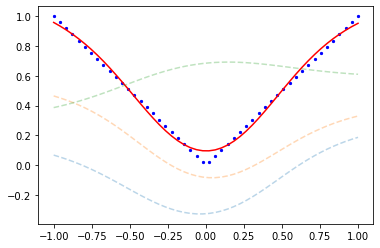

In [168]:
function = lambda x: np.abs(x)

num_examples = 50

function_x = torch.from_numpy(np.linspace(-1, 1, num_examples)).float()
function_y = torch.from_numpy(np.array(list(map(function, function_x))).reshape(num_examples, 1)).float()
input_ = function_x.reshape(num_examples, 1)

model = nn.Sequential(
    nn.Linear(1, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1)
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_func = nn.MSELoss()

for i in range(4000):
    optimizer.zero_grad()

    predictions = model.forward(input_)
    loss = loss_func(input=predictions, target=function_y)

    loss.backward()
    optimizer.step()

plt.plot(function_x.flatten(), predictions.detach().numpy(), c='r')
plt.scatter(function_x.flatten(), function_y.flatten(), c='b', s=5)
plt.plot(function_x, model[:6].forward(input_)[:,0].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')
plt.plot(function_x, model[:6].forward(input_)[:,1].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')
plt.plot(function_x, model[:6].forward(input_)[:,2].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')

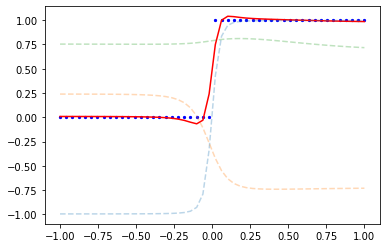

In [169]:
quadratic = lambda x: 1 if x > 0 else 0

num_examples = 50

function_x = torch.from_numpy(np.linspace(-1, 1, num_examples)).float()
function_y = torch.from_numpy(np.array(list(map(quadratic, function_x))).reshape(num_examples, 1)).float()
input_ = function_x.reshape(num_examples, 1)

model = nn.Sequential(
    nn.Linear(1, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_func = nn.MSELoss()

for i in range(4000):
    optimizer.zero_grad()

    predictions = model.forward(input_)
    loss = loss_func(input=predictions, target=function_y)

    loss.backward()
    optimizer.step()

plt.plot(function_x.flatten(), predictions.detach().numpy(), c='r')
plt.scatter(function_x.flatten(), function_y.flatten(), c='b', s=5)
plt.plot(function_x, model[:6].forward(input_)[:,0].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')
plt.plot(function_x, model[:6].forward(input_)[:,1].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')
plt.plot(function_x, model[:6].forward(input_)[:,2].flatten().detach().numpy(), alpha=0.30, linestyle='dashed')